In [2]:
Importing All Neccessary packagesimport torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import cv2
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
if(not os.path.exists('/content/drive')):
  drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
if not os.path.exists('Data'):
  with ZipFile('/content/drive/MyDrive/Projects/Instrument_classification/Train_specs.zip', 'r') as zf:
    zf.extractall('Data')
  with ZipFile('/content/drive/MyDrive/Projects/Instrument_classification/Test_specs.zip', 'r') as zf:
    zf.extractall('Data')

In [5]:
train_file_path = '/content/drive/MyDrive/Projects/Instrument_classification/Train_Data.csv'
test_file_path = '/content/drive/MyDrive/Projects/Instrument_classification/Test_Data.csv'
train_data_path = '/content/Data/Train_specs'
test_data_path = '/content/Data/Test_specs'

train_df_orig = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

print('SHAPES:')
print(f"Train: {train_df_orig.shape}")
print(f"Test: {test_df.shape}")

class_list = train_df_orig['Class'].unique()
print(f"\nClasses: {class_list}")

SHAPES:
Train: (2628, 2)
Test: (80, 2)

Classes: ['Sound_Guitar' 'Sound_Drum' 'Sound_Piano' 'Sound_Violin']


In [6]:
# getting image shape
train_img_list = os.listdir(train_data_path)
my_img_path = os.path.join(train_data_path, train_img_list[0])
my_img = cv2.imread(my_img_path, cv2.IMREAD_GRAYSCALE)
img_shape = my_img.shape
print(f"Image shape: {img_shape}")

Image shape: (256, 44)


In [7]:
# train_test_split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df_orig, test_size = 0.15, stratify=train_df_orig['Class'])
print("SHAPES:")
print(f'Train set: {train_df.shape}')
print(f'Val set: {val_df.shape}')

SHAPES:
Train set: (2233, 2)
Val set: (395, 2)


In [8]:
class InstrumentData(Dataset):
  def __init__(self, df, data_path, transform):
    self.df = df
    self.data_path = data_path
    self.transform = transform
    self.l = df.shape[0]

  def __len__(self):
    return self.l

  def __getitem__(self, idx):
    image_path = os.path.join(self.data_path, self.df.iloc[idx, 0])
    image_path = image_path[:-3] + 'png'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    label = self.df.iloc[idx, 1]

    image = self.transform(image)
    label = np.where(class_list == label)[0][0]

    return image, label

In [9]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Conv2d(1, 4, kernel_size=3)
    self.c2 = nn.Conv2d(4, 8, kernel_size=3)
    self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(8, 16, kernel_size=3)
    self.c4 = nn.Conv2d(16, 32, kernel_size=3)
    self.l1 = nn.Linear(32*30*3, 128)
    self.l2 = nn.Linear(128,32)
    self.l3 = nn.Linear(32,4)
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.c2(x))
    x = self.mp(x)
    x = self.act(self.c3(x))
    x = self.mp(x)
    x = self.act(self.c4(x))
    x = self.mp(x)
    x = x.view(-1, 32*30*3)
    x = self.act(self.l1(x))
    x = self.act(self.l2(x))
    x = self.l3(x)

    return x

In [37]:
transform = transforms.ToTensor()

train_dataset = InstrumentData(train_df, train_data_path, transform)
val_dataset = InstrumentData(val_df, train_data_path, transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [38]:
learning_rate = 0.001
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 40

In [39]:
import copy
# training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  epoch_loss = 0
  num_samples = 0
  num_correct=0

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      epoch_loss += loss.item()
      _, pred = torch.max(outputs, 1)
      num_samples += images.shape[0]
      num_correct += (pred == labels).sum().item()

  with torch.no_grad():
    val_loss = 0
    num_samples_val = 0
    num_correct_val = 0

    for idx, (images, labels) in enumerate(val_loader):
      images = images.to(device)
      labels = labels.to(device)

      val_out = model(images)
      val_loss_batch = criterion(val_out, labels)

      val_loss += val_loss_batch.item()
      _, val_pred = torch.max(val_out, 1)
      num_samples_val += images.shape[0]
      num_correct_val += (val_pred == labels).sum().item()

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    if epoch==0:
      best_loss = val_loss
      best_state_sict = copy.deepcopy(model.state_dict())
    if val_loss < best_loss:
      best_loss = val_loss
      best_state_dict = copy.deepcopy(model.state_dict())
    if epoch==num_epochs-1:
      last_state_dict = copy.deepcopy(model.state_dict())
      torch.save(last_state_dict, '/content/drive/MyDrive/Projects/Instrument_classification/last.pth')
      torch.save(best_state_dict, '/content/drive/MyDrive/Projects/Instrument_classification/best.pth')


    if (epoch)%4 == 0 or epoch==num_epochs-1:
      print(f'Epoch {epoch}: Train_loss={epoch_loss:.3f}, Val_loss={val_loss:.3f}, Train_accuracy={100*num_correct/num_samples:.4f}, Val_accuracy={100*num_correct_val/num_samples_val:.4f}')
      if epoch==num_epochs-1:
        print('*'*10,'TRAINING FINISHED','*'*10)



Epoch 0: Train_loss=43.918, Val_loss=19.357, Train_accuracy=41.5584, Val_accuracy=67.3418
Epoch 4: Train_loss=15.310, Val_loss=9.240, Train_accuracy=85.0425, Val_accuracy=88.1013
Epoch 8: Train_loss=8.392, Val_loss=5.107, Train_accuracy=91.8943, Val_accuracy=94.1772
Epoch 12: Train_loss=6.052, Val_loss=4.209, Train_accuracy=94.4917, Val_accuracy=94.9367
Epoch 16: Train_loss=3.571, Val_loss=3.453, Train_accuracy=96.5069, Val_accuracy=95.6962
Epoch 20: Train_loss=1.806, Val_loss=5.470, Train_accuracy=98.6117, Val_accuracy=95.6962
Epoch 24: Train_loss=1.375, Val_loss=5.515, Train_accuracy=99.1043, Val_accuracy=96.2025
Epoch 28: Train_loss=1.190, Val_loss=5.219, Train_accuracy=99.1491, Val_accuracy=95.6962
Epoch 32: Train_loss=0.867, Val_loss=5.745, Train_accuracy=99.3730, Val_accuracy=96.4557
Epoch 36: Train_loss=0.667, Val_loss=6.353, Train_accuracy=99.5074, Val_accuracy=95.6962
Epoch 39: Train_loss=0.599, Val_loss=7.667, Train_accuracy=99.5522, Val_accuracy=95.9494
********** TRAINING F

cuda:0


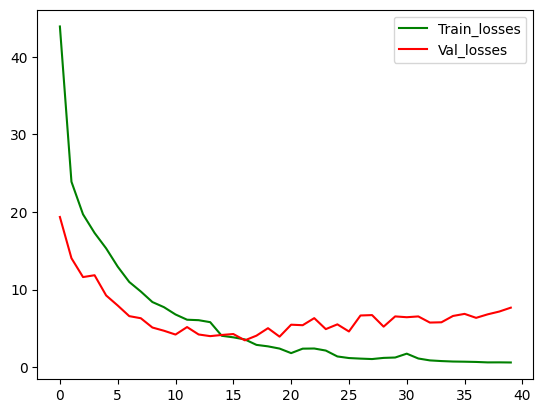

In [40]:
print(next(model.parameters()).device)
plt.plot(range(num_epochs), train_losses, 'g', label='Train_losses')
plt.plot(range(num_epochs), val_losses, 'r', label='Val_losses')
plt.legend()
plt.show()

In [46]:
test_dataset = InstrumentData(test_df, '/content/Data/Test_specs', transform)
test_loader = DataLoader(test_dataset)

test_model = Model()
best_state_dict = torch.load('/content/drive/MyDrive/Projects/Instrument_classification/best.pth', weights_only=True)
test_model.load_state_dict(best_state_dict)
test_model.to(device)

test_model.eval()
with torch.no_grad():
  total_correct = 0
  total_samples = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    test_outputs = test_model(images)
    _, test_preds = torch.max(test_outputs, 1)
    total_samples += images.shape[0]
    total_correct += (test_preds == labels).sum().item()

  print(f'Test Accuracy = {100*total_correct/total_samples:.4f}')

Test Accuracy = 73.7500
